In [ ]:
import os
from google.colab import drive

In [ ]:
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/DL/Best_model_weights')
# testfilename='D_pr_16_1009.pkl'
testfilename='D_pr_32_1009.pkl'
# testfilename='D-16-200pr_9.pkl'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import torch
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import math
import pdb


In [ ]:
import numpy as np
from itertools import cycle
from torchvision import datasets,transforms
from torch.utils.data import Dataset, DataLoader

import torch
from torch import nn
from torch.autograd import Variable
import pdb

from __future__ import print_function 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader,TensorDataset
import sys


In [ ]:
def log_sum_exp(x, axis = 1):
    m = torch.max(x, dim = 1)[0]
    return m + torch.log(torch.sum(torch.exp(x - m.unsqueeze(1)), dim = axis))
def reset_normal_param(L, stdv, weight_scale = 1.):
    assert type(L) == torch.nn.Linear
    torch.nn.init.normal(L.weight, std=weight_scale / math.sqrt(L.weight.size()[0]))
    
class LinearWeightNorm(torch.nn.Module):
    def __init__(self, in_features, out_features, bias=True, weight_scale=None, weight_init_stdv=0.1):
        super(LinearWeightNorm, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.randn(out_features, in_features) * weight_init_stdv)
        if bias:
            self.bias = Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)
        if weight_scale is not None:
            assert type(weight_scale) == int
            self.weight_scale = Parameter(torch.ones(out_features, 1) * weight_scale)
        else:
            self.weight_scale = 1 
    def forward(self, x):
        W = self.weight * self.weight_scale / torch.sqrt(torch.sum(self.weight ** 2, dim = 1, keepdim = True))
        return F.linear(x, W, self.bias)
    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'in_features=' + str(self.in_features) \
            + ', out_features=' + str(self.out_features) \
            + ', weight_scale=' + str(self.weight_scale) + ')'

In [ ]:
#DATALOADER 
import random
def MNISTunlab():
    dmnist = datasets.MNIST( root='mnist', download=True, train=True,  transform=transforms.Compose([
                    transforms.ToTensor(),
                ]))

    return dmnist

def MnistLabel(class_num, perimg):
    raw_dataset = datasets.MNIST(root='mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))
    class_tot = [0] * class_num
    data = []
    labels = []
    tot = 0
    perm = np.random.permutation(raw_dataset.__len__())
    for i in range(raw_dataset.__len__()):
        datum, label = raw_dataset.__getitem__(perm[i])
        if class_tot[label] < perimg:  
            data.append(datum.numpy())
            labels.append(label)
            class_tot[label] += 1
            tot += 1
            if tot >= perimg * class_num:
                break
    return TensorDataset(torch.FloatTensor(np.array(data)), torch.LongTensor(np.array(labels)))
prec1 = 0.0;
prec2 = 0.0;
if(testfilename=='D-16-200pr_9.pkl'):
  prec1+=0.01
  prec2+=0.01        
class MNIST_triplet():
    def __init__(self, root='mnist', download=True, train=True,sampleSize=100):
        self.mnist = datasets.MNIST( root='mnist', download=True, train=True,  transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))
        self.data_dict = {}

        for i in range(self.__len__()):
            image, label = self.mnist.__getitem__(i)
            try:
                self.data_dict[label]
            except KeyError:
                self.data_dict[label] = []
            self.data_dict[label].append(image)
        
        sampleImages={}
        triplets=[]
        numberofimgs=int(sampleSize/10)
        for i in range(10):
          siz=len(self.data_dict[i])
          x=random.sample(range(siz), numberofimgs)##index
          for j in range(len(x)):
            try:
                sampleImages[i]
            except KeyError:
                sampleImages[i] = []

            sampleImages[i].append(self.data_dict[i][x[j]])

        for i in range(10):
          for j in range(numberofimgs):
            for k in range(numberofimgs):
              for l in range(10):
                if i!=l:
                  for p in range(numberofimgs):
                    ob=[]
                    ob.append(sampleImages[i][j])
                    ob.append(sampleImages[i][k])
                    ob.append(sampleImages[l][p])
                    triplets.append(ob)

        # print(len(triplets))
        random.shuffle(triplets)
        self.triplets=triplets[:60000]
        # print(len(self.mnist[0]))
        # print(len(self.triplets[0]))


    def __len__(self):
      return self.mnist.__len__() 

    def __getitem__(self,index):
      return self.triplets[index]

def MnistTest():
    return datasets.MNIST('mnist', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))
#---------------------------------------------------


In [ ]:
# Models
class Discriminator(nn.Module):
    def __init__(self, input_dim = 28 ** 2, output_dim = 32):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.layers = torch.nn.ModuleList([
            LinearWeightNorm(input_dim, 1000),
            LinearWeightNorm(1000, 500),
            LinearWeightNorm(500, 250),
            LinearWeightNorm(250, 250),
            LinearWeightNorm(250, 250)]
        )
        self.final = LinearWeightNorm(250, output_dim, weight_scale=1)

    def forward(self, x, feature = False, cuda = False):
        x = x.view(-1, self.input_dim)
        noise = torch.randn(x.size()) * 0.3 if self.training else torch.Tensor([0])
        if cuda:
            noise = noise.cuda()
        x = x + Variable(noise, requires_grad = False)
        for i in range(len(self.layers)):
            m = self.layers[i]
            x_f = F.relu(m(x))
            noise = torch.randn(x_f.size()) * 0.5 if self.training else torch.Tensor([0])
            if cuda:
                noise = noise.cuda()
            x = (x_f + Variable(noise, requires_grad = False))
        if feature:
            return x_f, self.final(x)
        return self.final(x)


class Generator(nn.Module):
    def __init__(self, z_dim, output_dim = 28 ** 2):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.fc1 = nn.Linear(z_dim, 500, bias = False)
        self.bn1 = nn.BatchNorm1d(500, affine = False, eps=1e-6, momentum = 0.5)
        self.fc2 = nn.Linear(500, 500, bias = False)
        self.bn2 = nn.BatchNorm1d(500, affine = False, eps=1e-6, momentum = 0.5)
        self.fc3 = LinearWeightNorm(500, output_dim, weight_scale = 1)
        self.bn1_b = Parameter(torch.zeros(500))
        self.bn2_b = Parameter(torch.zeros(500))
        nn.init.xavier_uniform(self.fc1.weight)
        nn.init.xavier_uniform(self.fc2.weight)

    def forward(self, batch_size, cuda = False):
        x = Variable(torch.rand(batch_size, self.z_dim), requires_grad = False, volatile = not self.training)
        if cuda:
            x = x.cuda()
        x = F.softplus(self.bn1(self.fc1(x)) + self.bn1_b)
        x = F.softplus(self.bn2(self.fc2(x)) + self.bn2_b)
        x = F.softplus(self.fc3(x))
        return x

In [ ]:
import time
#hyperparameters
savedir=False
cuda=True
lr = 0.003
batch_size=100
momentum=0.5
loginterval=100
epochs=10
unlabelweight=1
def loss_labeled(a,b,c):
      n_plus = torch.sqrt(torch.sum((a - b)**2, axis=1));
      n_minus = torch.sqrt(torch.sum((a - c)**2, axis=1));
      z = torch.cat([n_minus.unsqueeze(1),n_plus.unsqueeze(1)],axis=1)
      z = log_sum_exp(z,axis=1)
      return n_plus,n_minus,z
tripLosses=[]
unsupervisedLosses=[]
genLosses=[]
accuracytrain=[]
accuracyval=[]
class ImprovedGAN(object):
    def __init__(self, G, D, triplets,labeled, unlabeled, test):
        # if os.path.exists(savedir):
        #     # print('Loading model from ' + savedir)
        #     # self.G = torch.load(os.path.join(args.savedir, 'G.pkl'))
        #     # self.D = torch.load(os.path.join(args.savedir, 'D.pkl'))
        # else:
            # os.makedirs(savedir)
        G=G.cuda()
        D=D.cuda()
        G=torch.load('/content/drive/My Drive/DL/EndSem/pretrained/pretrainedG49.pkl')
        D=torch.load('/content/drive/My Drive/DL/EndSem/pretrained/pretrainedD49.pkl')
        self.G=G
        self.D=D
        self.triplets = triplets
        self.unlabeled = unlabeled
        self.labeled = labeled
        self.test = test
        self.Doptim = optim.Adam(self.D.parameters(), lr=lr, betas= (momentum, 0.999))
        self.Goptim = optim.Adam(self.G.parameters(), lr=lr, betas = (momentum,0.999))
        # self.args = args

    def trainD(self, a, b,c,x_label,y, x_unlabel): ## repalce x_label,y and give triplet iteself
        x_label,x_unlabel,y,a,b,c = Variable(x_label), Variable(x_unlabel), Variable(y, requires_grad = False), Variable(a), Variable(b), Variable(c)
        x_label=x_label.cuda()
        y=y.cuda()
        x_unlabel=x_unlabel.cuda()
        a=a.cuda()
        b=b.cuda()
        c=c.cuda()
        output_label,output_unlabel, output_fake = self.D(x_label, cuda=True), self.D(x_unlabel, cuda=True), self.D(self.G(x_unlabel.size()[0], cuda =True).view(x_unlabel.size()).detach(), cuda=True)
        logz_unlabel, logz_fake = log_sum_exp(output_unlabel), log_sum_exp(output_fake) # log ∑e^x_i
        a_lab,b_lab,c_lab = self.D(a, cuda=True),self.D(b, cuda=True),self.D(c, cuda=True)
        ##### TRIPLET LOSS
        n_plus_lab,n_minus_lab,z_lab = loss_labeled(a_lab,b_lab,c_lab)
        loss_supervised =  -torch.mean(n_minus_lab) + torch.mean(z_lab)
        loss_unsupervised = 0.5 * (-torch.mean(logz_unlabel) + torch.mean(F.softplus(logz_unlabel))  + # real_data: log Z/(1+Z)
                            torch.mean(F.softplus(logz_fake)) ) # fake_data: log 1/(1+Z)
        loss = loss_supervised + unlabelweight * loss_unsupervised
        acc = torch.mean((output_label.max(1)[1] == y).float())
        self.Doptim.zero_grad()
        loss.backward()
        self.Doptim.step()
        return loss_supervised.data.cpu().numpy(), loss_unsupervised.data.cpu().numpy(),acc
    
    def trainG(self, x_unlabel):
        fake = self.G(x_unlabel.size()[0], cuda = True).view(x_unlabel.size())
        mom_gen, output_fake = self.D(fake, feature=True, cuda=True)
        mom_unlabel, _ = self.D(Variable(x_unlabel), feature=True, cuda=True)
        mom_gen = torch.mean(mom_gen, dim = 0)
        mom_unlabel = torch.mean(mom_unlabel, dim = 0)
        loss_fm = torch.mean((mom_gen - mom_unlabel) ** 2)
        loss = loss_fm 
        self.Goptim.zero_grad()
        self.Doptim.zero_grad()
        loss.backward()
        self.Goptim.step()
        return loss.data.cpu().numpy()


    def train_real(self):
      
      times = int(np.ceil(self.unlabeled.__len__() * 1. / self.labeled.__len__()))
      t1 = self.labeled.tensors[0].clone()
      t2 = self.labeled.tensors[1].clone()
      tile_labeled = TensorDataset(t1.repeat(times,1,1,1),t2.repeat(times))
      for epoch in range(10):
        print(epoch)
        loss_supervised = loss_unsupervised = loss_gen = accuracy = 0.
        self.G.train()
        self.D.train()
        unlabel_loader1 = DataLoader(self.unlabeled, batch_size = 100, shuffle=True, drop_last=True, num_workers = 4)
        unlabel_loader2 = DataLoader(self.unlabeled, batch_size = 100, shuffle=True, drop_last=True, num_workers = 4).__iter__()
        label_loader = DataLoader(tile_labeled, batch_size = 100, shuffle=True, drop_last=True, num_workers = 4).__iter__()
        triplet_loader = DataLoader(self.triplets, batch_size = 100, shuffle=True, drop_last=True, num_workers = 4).__iter__()

        begin = time.time()
        batch_num=0
        for (unlabel1, _label1) in unlabel_loader1:
          batch_num += 1
          unlabel2, _label2 = unlabel_loader2.next()
          a,b,c= triplet_loader.next()
          x, y = label_loader.next()
          unlabel2=unlabel2.cuda()
          unlabel1=unlabel1.cuda()
          a=a.cuda()
          b=b.cuda()
          c=c.cuda()
          x=x.cuda()
          y=y.cuda()
          ll, lu, acc = self.trainD(a, b,c,x,y,unlabel1)
          loss_supervised+=ll
          loss_unsupervised+=lu
          accuracy+=acc
          lg = self.trainG(unlabel2)
          if epoch > 1 and lg > 1:
              lg = self.trainG(unlabel2)
          loss_gen += lg
          if (batch_num + 1) % 100 == 0:
            print('Training: %d / %d' % (batch_num + 1, len(unlabel_loader1)))      
        loss_supervised /= batch_num
        loss_unsupervised /= batch_num
        loss_gen /= batch_num
        accuracy /= batch_num
        print("Iteration %d, loss_supervised = %.4f, loss_unsupervised = %.4f, loss_gen = %.4f train acc = %.4f " % (epoch, loss_supervised, loss_unsupervised, loss_gen,accuracy))
        tripLosses.append(loss_supervised)
        unsupervisedLosses.append(loss_unsupervised)
        genLosses.append(loss_gen)
        accuracytrain.append(accuracy)

        accval=self.eval()
        print("Eval: correct %d / %d"  % (accval, self.test.__len__()))
        torch.save(self.G, os.path.join( 'G-16-200pr_'+str(epoch)+'.pkl'))
        torch.save(self.D, os.path.join( 'D-16-200pr_'+str(epoch)+'.pkl'))
        accuracyval.append(accval) 

      import matplotlib.pyplot as plt 
      ep=list(range(0,10))
      plt.plot(ep,tripLosses) 
      # naming the x axis 
      plt.xlabel('Epochs') 
      # naming the y axis 
      plt.ylabel('Triplet Loss') 
      # giving a title to my graph 
      plt.title('Triplet Loss Plot') 
      # function to show the plot 
      plt.show() 
      plt.plot(ep,unsupervisedLosses) 
      # naming the x axis 
      plt.xlabel('Epochs') 
      # naming the y axis 
      plt.ylabel('Unsupervised Loss') 
      # giving a title to my graph 
      plt.title('Unsupervised Loss Plot') 
      plt.figure()
      plt.show() 
      plt.plot(ep,genLosses) 
      # naming the x axis 
      plt.xlabel('Epochs') 
      # naming the y axis 
      plt.ylabel('Generator Loss') 
      # giving a title to my graph 
      plt.title('Generator Loss Plot') 
      plt.figure()
      plt.show()


    def predict(self, x):
        with torch.no_grad():
            ret = torch.max(self.D(Variable(x), cuda=True), 1)[1].data
        return ret

    def eval(self):
        self.G.eval()
        self.D.eval()
        d, l = [], []
        for (datum, label) in self.test:
            d.append(datum)
            l.append(label)
        x, y = torch.stack(d), torch.LongTensor(l)
        x, y = x.cuda(), y.cuda()
        pred = self.predict(x)
        return torch.sum(pred == y)
        
    def draw(self, batch_size):
        self.G.eval()
        return self.G(batch_size, cuda=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


0
Training: 100 / 600
Training: 200 / 600
Training: 300 / 600
Training: 400 / 600
Training: 500 / 600
Training: 600 / 600
Iteration 0, loss_supervised = 0.0499, loss_unsupervised = 0.4584, loss_gen = 3.3425 train acc = 0.0143 
Eval: correct 89 / 10000
1


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LinearWeightNorm. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Training: 100 / 600
Training: 200 / 600
Training: 300 / 600
Training: 400 / 600
Training: 500 / 600
Training: 600 / 600
Iteration 1, loss_supervised = 0.0050, loss_unsupervised = 0.4004, loss_gen = 3.1711 train acc = 0.0126 
Eval: correct 103 / 10000
2
Training: 100 / 600
Training: 200 / 600
Training: 300 / 600
Training: 400 / 600
Training: 500 / 600
Training: 600 / 600
Iteration 2, loss_supervised = 0.0027, loss_unsupervised = 0.4177, loss_gen = 2.6768 train acc = 0.0134 
Eval: correct 69 / 10000
3
Training: 100 / 600
Training: 200 / 600
Training: 300 / 600
Training: 400 / 600
Training: 500 / 600
Training: 600 / 600
Iteration 3, loss_supervised = 0.0024, loss_unsupervised = 0.4200, loss_gen = 2.4250 train acc = 0.0131 
Eval: correct 79 / 10000
4
Training: 100 / 600
Training: 200 / 600
Training: 300 / 600
Training: 400 / 600
Training: 500 / 600
Training: 600 / 600
Iteration 4, loss_supervised = 0.0015, loss_unsupervised = 0.4240, loss_gen = 2.3512 train acc = 0.0174 
Eval: correct 80 /

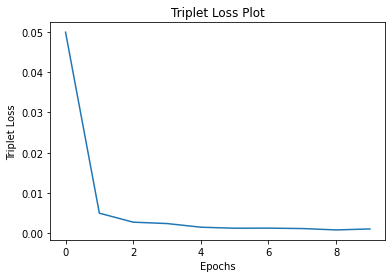

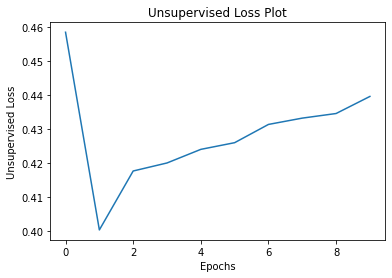

<Figure size 432x288 with 0 Axes>

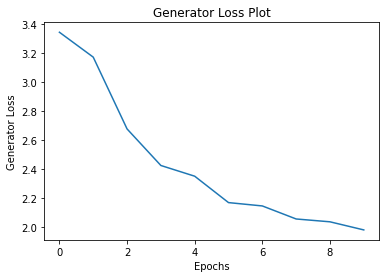

<Figure size 432x288 with 0 Axes>

In [ ]:

    # parser = argparse.ArgumentParser(description='PyTorch Improved GAN')
    # parser.add_argument('--batch-size', type=int, default=100, metavar='N',
    #                     help='input batch size for training (default: 64)')
    # parser.add_argument('--epochs', type=int, default=10, metavar='N',
    #                     help='number of epochs to train (default: 10)')
    # parser.add_argument('--lr', type=float, default=0.003, metavar='LR',
    #                     help='learning rate (default: 0.003)')
    # parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
    #                     help='SGD momentum (default: 0.5)')
    # parser.add_argument('--cuda', action='store_true', default=False,
    #                     help='CUDA training')
    # parser.add_argument('--seed', type=int, default=1, metavar='S',
    #                     help='random seed (default: 1)')
    # parser.add_argument('--log-interval', type=int, default=100, metavar='N',
    #                     help='how many batches to wait before logging training status')
    # parser.add_argument('--eval-interval', type=int, default=1, metavar='N',
    #                     help='how many epochs to wait before evaling training status')
    # parser.add_argument('--unlabel-weight', type=float, default=1, metavar='N',
    #                     help='scale factor between labeled and unlabeled data')
    # parser.add_argument('--logdir', type=str, default='./logfile', metavar='LOG_PATH', help='logfile path, tensorboard format')
    # parser.add_argument('--savedir', type=str, default='./models', metavar='SAVE_PATH', help = 'saving path, pickle format')
    # args = parser.parse_args()
    # args.cuda = args.cuda and torch.cuda.is_available()
    # seed=1
    # np.random.seed(seed)

mnisttrip=MNIST_triplet()
gan = ImprovedGAN(Generator(100), Discriminator(),mnisttrip, MnistLabel(10,10), MNISTunlab(), MnistTest())
gan.train_real()

In [ ]:
train_features=[]
test_features=[]
train_labels=[]
test_labels=[]

disc=Discriminator()
disc=torch.load(testfilename)

# tr=MNISTunlab()
# for (i,j) in tr:
#   train_labels.append(j)
#   train_features.append(disc(i.cuda(),cuda=True))

unlabel_loader1 = DataLoader(MNISTunlab(), batch_size = 600,  drop_last=True, num_workers = 4)
for (i,j) in unlabel_loader1:
  train_labels+=j.tolist()
  train_features+=((disc(i.cuda(),cuda=True)).tolist())



# print(train_labels)
# print(len(train_labels)) 
# print(len(train_features[0]))
# print(len(train_features)) 



unlabel_loader1 = DataLoader(MnistTest(), batch_size = 200, drop_last=True, num_workers = 4)
for (i,j) in unlabel_loader1:
  test_labels+=j.tolist()
  test_features+=((disc(i.cuda(),cuda=True)).tolist())

print(test_labels)
print(len(test_labels)) 
print(len(test_features[0]))
print(len(test_features)) 




[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1, 5, 9, 8, 7, 2, 3, 0, 4, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 6, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 8, 2, 9, 2, 0, 4, 0, 0, 2, 8, 4, 7, 1, 2, 4, 0, 2, 7, 4, 3, 3, 0, 0, 3, 1, 9, 6, 5, 2, 5, 9, 2, 9, 3, 0, 4, 2, 0, 7, 1, 1, 2, 1, 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn= KNeighborsClassifier(n_neighbors=9)
knn.fit(train_features,train_labels)
res=knn.predict(test_features)
correct=(res==test_labels).sum()
print(correct)
print(len(test_labels))
print(correct/len(test_labels))

train_labels=np.asarray(train_labels)
test_labels=np.asarray(test_labels)


9716
10000
0.9716


In [ ]:
from sklearn.metrics import average_precision_score
from scipy.spatial.distance import cdist
Y = cdist(test_features[:5000],train_features)
ind = np.argsort(Y,axis=1)
prec = 0.0;
acc = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0];
# calculating statistics

# print(len(np.shape(test_features)[0]):))
for k in range(np.shape(test_features[:5000])[0]):
    class_values = train_labels[ind[k,:]]
    y_true = (test_labels[:5000][k] == class_values)
    y_scores = np.arange(y_true.shape[0],0,-1)
    ap = average_precision_score(y_true, y_scores)
    prec = prec + ap
    for n in range(len(acc)):
        a = class_values[0:(n+1)]
        counts = np.bincount(a)
        b = np.where(counts==np.max(counts))[0]
        if test_labels[:5000][k] in b:
            acc[n] = acc[n] + (1.0/float(len(b)))

prec = prec/float(np.shape(test_features[:5000])[0])
acc= [x / float(np.shape(test_features[:5000])[0]) for x in acc]
print("Final results: ")
print("mAP value: %.4f "% prec)


Final results: 
mAP value: 0.8953 


In [ ]:
prec1+=prec
Y = cdist(test_features[5000:],train_features)
ind = np.argsort(Y,axis=1)
prec = 0.0;
acc = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0];
# calculating statistics

# print(len(np.shape(test_features)[0]):))
for k in range(np.shape(test_features[5000:])[0]):
    class_values = train_labels[ind[k,:]]
    y_true = (test_labels[5000:][k] == class_values)
    y_scores = np.arange(y_true.shape[0],0,-1)
    ap = average_precision_score(y_true, y_scores)
    prec = prec + ap
    for n in range(len(acc)):
        a = class_values[0:(n+1)]
        counts = np.bincount(a)
        b = np.where(counts==np.max(counts))[0]
        if test_labels[5000:][k] in b:
            acc[n] = acc[n] + (1.0/float(len(b)))

prec = prec/float(np.shape(test_features[5000:])[0])
acc= [x / float(np.shape(test_features[5000:])[0]) for x in acc]
print("Final results: ")
print("mAP value: %.4f "% prec)
prec2+=prec

Final results: 
mAP value: 0.9530 


In [ ]:
print("Final avg mAP")
print((prec1+prec2)/2)

Final avg mAP
1.8511209130798352


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


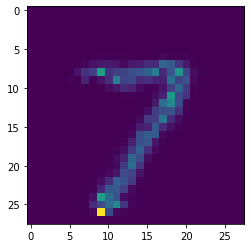

In [ ]:
generator = Generator(100)
generator=generator.cuda()
generator=torch.load('/content/drive/My Drive/DL/EndSem/pretrained_32/pretrained_32_G49.pkl')
gen_imgs = generator(10,cuda=True)
aaa=torch.reshape(gen_imgs[0],(28,28)).data.cpu().numpy()
import matplotlib.pyplot as plt 
c = plt.imshow(aaa)
plt.show()